# **HAR70+ Dataset: Data Preprocessing & Z-Score Normalization**
## **Step 1: Load & Normalize Each Subject's Data Individually**


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set the path where CSV files are stored
data_path = "har70plus"  # UPDATE THIS TO YOUR DATA DIRECTORY

# List all CSV files
csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]

# Define sensor columns to normalize (EXCLUDE timestamp & label)
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Storage for normalized data
normalized_data = []

# Process each subject file independently
for file in csv_files:
    subject_id = file.split(".")[0]  # Extract subject ID from filename
    file_path = os.path.join(data_path, file)
    
    # Read the CSV
    df = pd.read_csv(file_path)
    
    # Ensure timestamp is in datetime format
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    # Add subject_id as a new column
    df["subject_id"] = subject_id
    
    # Apply Z-score normalization ONLY to sensor readings (exclude timestamp & label)
    scaler = StandardScaler()
    df[sensor_columns] = scaler.fit_transform(df[sensor_columns])
    
    # Store the processed dataframe
    normalized_data.append(df)

# Merge all normalized subjects into a single DataFrame
df_all_normalized = pd.concat(normalized_data, ignore_index=True)

# Display the structure of the normalized dataset
df_all_normalized.head()


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
0,2021-03-24 14:42:03.839,-0.346465,0.046882,0.344367,-0.310578,-0.078194,0.493743,6,501
1,2021-03-24 14:42:03.859,-0.291337,-0.076518,0.344367,-0.278401,-0.123405,0.487053,6,501
2,2021-03-24 14:42:03.880,-0.203269,-0.053734,0.344367,-0.258850,0.071362,0.458953,6,501
3,2021-03-24 14:42:03.900,-0.216874,0.081058,0.343782,-0.272292,0.234822,0.488838,6,501
4,2021-03-24 14:42:03.920,-0.268424,0.206355,0.349627,-0.304876,0.341479,0.532995,6,501


## **Step 2: Visualization**
Compare raw vs. normalized sensor readings for a sample subject.


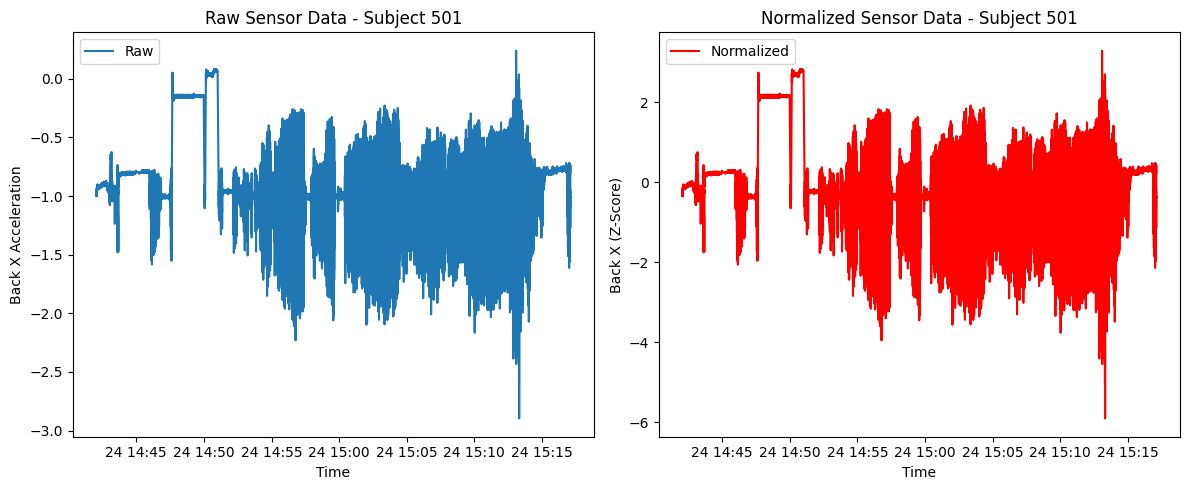

In [2]:
# Select a random subject for visualization
sample_subject = csv_files[0].split(".")[0]

# Reload raw data for this subject
raw_file_path = os.path.join(data_path, f"{sample_subject}.csv")
df_raw = pd.read_csv(raw_file_path)
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"])

# Get normalized data for the same subject
df_norm = df_all_normalized[df_all_normalized["subject_id"] == sample_subject]

# Plot raw vs. normalized 'back_x' readings
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_raw["timestamp"], df_raw["back_x"], label="Raw")
plt.title(f"Raw Sensor Data - Subject {sample_subject}")
plt.xlabel("Time")
plt.ylabel("Back X Acceleration")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_norm["timestamp"], df_norm["back_x"], label="Normalized", color='red')
plt.title(f"Normalized Sensor Data - Subject {sample_subject}")
plt.xlabel("Time")
plt.ylabel("Back X (Z-Score)")
plt.legend()

plt.tight_layout()
plt.show()


# **Step 3: Compute 30-Second Moving Averages**
## Why? To smooth data and analyze trends per activity.


In [3]:
# Define the window size (30 seconds)
window_size = 30  # Assuming data is sampled at 50Hz, this means 1500 samples per window

# Apply moving average per subject and label
df_smoothed = df_all_normalized.copy()
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Compute moving average for each subject separately
df_smoothed[sensor_columns] = df_all_normalized.groupby(['subject_id', 'label'])[sensor_columns].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# Display the first few rows of smoothed data
df_smoothed.head()
# Verify that the means of the sensor columns are close to zero before moving average
print(df_all_normalized[sensor_columns].mean())
print(df_smoothed[sensor_columns].mean())

back_x     8.170812e-17
back_y    -2.817521e-17
back_z    -3.582277e-17
thigh_x   -3.059023e-17
thigh_y    1.549637e-17
thigh_z    5.474042e-17
dtype: float64
back_x    -0.000113
back_y     0.000048
back_z    -0.000035
thigh_x    0.000033
thigh_y   -0.000029
thigh_z   -0.000044
dtype: float64


## **Step 4: Visualizing Sensor Distributions per Activity**
### **Goal:** Identify which sensors have the most variation across activities.


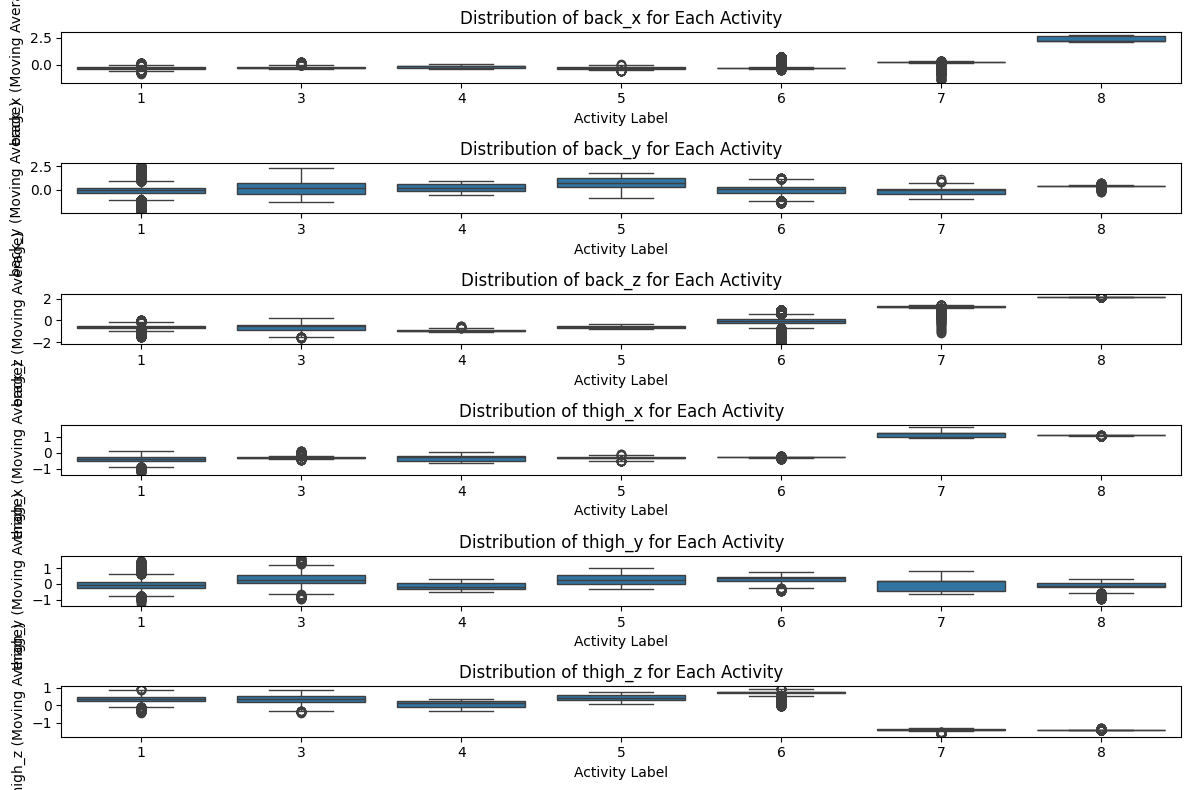

In [4]:
import seaborn as sns

# Select a sample subject to visualize
sample_subject = df_smoothed["subject_id"].unique()[0]
df_sample = df_smoothed[df_smoothed["subject_id"] == sample_subject]

# Plot the moving average distributions for each activity (label)
plt.figure(figsize=(12, 8))

for i, sensor in enumerate(sensor_columns[:6]):  # Visualizing first three sensors
    plt.subplot(6, 1, i+1)
    sns.boxplot(x="label", y=sensor, data=df_sample)
    plt.title(f"Distribution of {sensor} for Each Activity")
    plt.xlabel("Activity Label")
    plt.ylabel(f"{sensor} (Moving Average)")

plt.tight_layout()
plt.show()


# **Feature Selection for HAR70+ Dataset**
## **Step 1: Statistical Analysis of Feature Importance**
### **Goal**
To determine which sensor readings are the most important for distinguishing activity states.  
We will use:
1. **ANOVA (Analysis of Variance):** Tests if different activities have significantly different sensor readings.
2. **Kruskal-Wallis Test:** A non-parametric alternative for non-normal data.
3. **Feature Correlation with Labels:** Measures how strongly each sensor reading relates to activity states.
4. **Random Forest Feature Importance:** Provides a direct ranking of sensor importance in classification.

---


In [5]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

# Define the sensor columns to analyze
sensor_columns = ['back_x', 'back_z', 'thigh_x', 'thigh_z']

# Perform ANOVA test across activity labels for selected sensors
anova_results = {sensor: f_oneway(*[df_smoothed[df_smoothed["label"] == lbl][sensor] 
                                    for lbl in df_smoothed["label"].unique()])
                 for sensor in sensor_columns}

# Extract and display ANOVA p-values
anova_pvalues = {k: v.pvalue for k, v in anova_results.items()}
print("ANOVA p-values:", anova_pvalues)

# Perform Kruskal-Wallis test (alternative for non-normal distributions)
kruskal_results = {sensor: kruskal(*[df_smoothed[df_smoothed["label"] == lbl][sensor] 
                                     for lbl in df_smoothed["label"].unique()])
                   for sensor in sensor_columns}

# Extract and display Kruskal-Wallis p-values
kruskal_pvalues = {k: v.pvalue for k, v in kruskal_results.items()}
print("Kruskal-Wallis p-values:", kruskal_pvalues)


ANOVA p-values: {'back_x': 0.0, 'back_z': 0.0, 'thigh_x': 0.0, 'thigh_z': 0.0}
Kruskal-Wallis p-values: {'back_x': 0.0, 'back_z': 0.0, 'thigh_x': 0.0, 'thigh_z': 0.0}


## **Step 2: Interpreting the Statistical Results**
Both **ANOVA** and **Kruskal-Wallis** tests evaluate whether the mean values of each sensor differ significantly across activity labels.

### **How to Interpret the p-values?**
- **p-value < 0.05:** The feature has a statistically significant difference across activities.
- **p-value ≈ 0.0:** The feature is extremely significant for distinguishing activities.
- **p-value > 0.05:** The feature is likely **not useful** for classification.

### **Our Results**
- Since all **p-values are 0.0**, we reject the null hypothesis.
- **Conclusion:** These features **significantly differ** between activity labels and are highly relevant.



## **Step 3: Correlation of Features with Activity Labels**
To further validate feature importance, we check how strongly each sensor correlates with activity labels.


In [6]:
# Compute correlation of selected sensors with activity labels
correlation_values = df_smoothed[sensor_columns].corrwith(df_smoothed["label"])

# Sort and display
correlation_values = correlation_values.abs().sort_values(ascending=False)
print("Feature correlations with activity labels:\n", correlation_values)


Feature correlations with activity labels:
 thigh_x    0.757384
back_z     0.722276
thigh_z    0.656513
back_x     0.533205
dtype: float64


## **Step 4: Using Random Forest for Feature Importance**
To confirm our findings, we train a **Random Forest classifier** and measure how much each feature contributes to classification accuracy.


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare dataset for classification
X = df_smoothed[sensor_columns]
y = df_smoothed["label"]

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.Series(clf.feature_importances_, index=sensor_columns).sort_values(ascending=False)

# Display feature importance values
print("Feature Importance from Random Forest:\n", feature_importance)


Feature Importance from Random Forest:
 thigh_x    0.303914
thigh_z    0.271490
back_z     0.219665
back_x     0.204931
dtype: float64


## **Step 5: Visualizing Feature Importance**
A bar chart of feature importance scores helps us confirm which sensors are the most influential in predicting activity states.


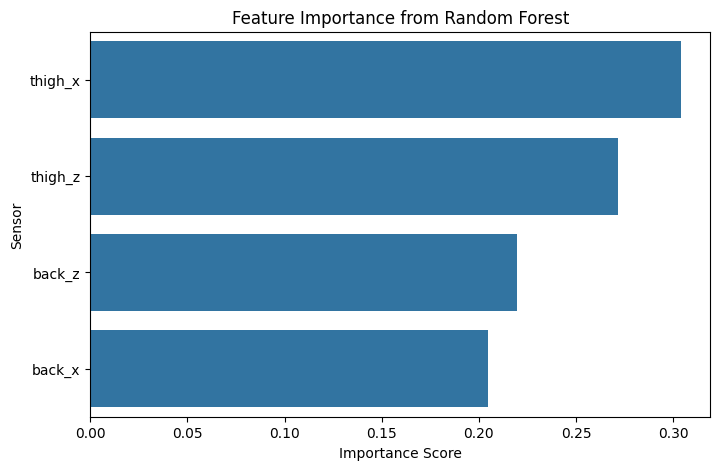

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Sensor")
plt.show()


# **Step: Train a Baseline Classifier (Random Forest)**
## **Goal:** Classify activities using selected important features.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the selected features and label
selected_features = ['thigh_x', 'thigh_z', 'back_z', 'back_x']
X = df_smoothed[selected_features]
y = df_smoothed["label"]

# Split into train-test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Display detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9526
Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.98      0.96    215863
           3       0.78      0.29      0.42     13212
           4       0.87      0.58      0.69       912
           5       0.85      0.37      0.51       996
           6       0.93      0.92      0.93     83611
           7       1.00      1.00      1.00     96690
           8       1.00      1.00      1.00     40636

    accuracy                           0.95    451920
   macro avg       0.91      0.73      0.79    451920
weighted avg       0.95      0.95      0.95    451920



## **Step: Visualize the Model Performance**
A **confusion matrix** helps us understand misclassifications.


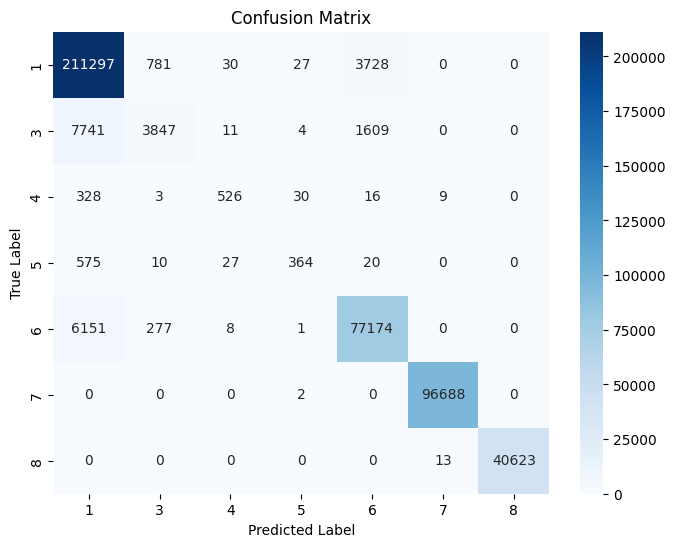

In [10]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# **Step: Prepare Data for LSTM with 5Hz Sampling (down from the original 50)**
## **Goal:** Use the past 2 minutes (600 samples) to predict the next 30 seconds (150 samples).


In [15]:
# Downsample dataset: Keep only every 10th row (5Hz from 50Hz)
df_downsampled = df_smoothed.iloc[::10].reset_index(drop=True)

# Print new shape
print(f"Original dataset size: {df_smoothed.shape}")
print(f"Downsampled dataset size (5Hz): {df_downsampled.shape}")

# Updated sequence lengths based on 5Hz sampling
look_back = 600  # 2 minutes = 600 samples at 5Hz
forecast_horizon = 150  # 30 seconds = 150 samples at 5Hz

# Increase batch size for efficiency
batch_size = 128



Original dataset size: (2259597, 10)
Downsampled dataset size (5Hz): (225960, 10)


## **Step: Build and Train the LSTM Model**


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df_downsampled["label_encoded"] = label_encoder.fit_transform(df_downsampled["label"])

# Define selected features
selected_features = ['thigh_x', 'thigh_z', 'back_z', 'back_x']

# Custom Data Generator for Efficient Loading
class HARDataGenerator(Sequence):
    def __init__(self, df, features, label_col, look_back, forecast_horizon, batch_size=128):
        self.df = df
        self.features = features
        self.label_col = label_col
        self.look_back = look_back
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.num_samples = len(df) - look_back - forecast_horizon

    def __len__(self):
        return self.num_samples // self.batch_size  # Number of batches per epoch

    def __getitem__(self, idx):
        """Loads one batch at a time"""
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        
        X_batch = np.zeros((self.batch_size, self.look_back, len(self.features)), dtype=np.float32)
        y_batch = np.zeros(self.batch_size, dtype=np.int32)

        for i in range(self.batch_size):
            seq_idx = start_idx + i
            X_batch[i] = self.df[self.features].values[seq_idx:seq_idx + self.look_back]
            y_batch[i] = self.df[self.label_col].iloc[seq_idx + self.look_back + self.forecast_horizon]

        y_batch = to_categorical(y_batch, num_classes=len(label_encoder.classes_))
        return X_batch, y_batch

# Use downsampled dataset for training
train_size = int(0.8 * len(df_downsampled))
train_gen = HARDataGenerator(df_downsampled[:train_size], selected_features, "label_encoded", look_back, forecast_horizon, batch_size=batch_size)
val_gen = HARDataGenerator(df_downsampled[train_size:], selected_features, "label_encoded", look_back, forecast_horizon, batch_size=batch_size)

print(f"Total training batches: {len(train_gen)}")
print(f"Total validation batches: {len(val_gen)}")


Total training batches: 1406
Total validation batches: 347


## **Step: Evaluate the LSTM Model**


In [24]:
import numpy as np
import tensorflow as tf

# Define features to predict (same as input)
selected_features = ['thigh_x', 'thigh_z', 'back_z', 'back_x']

# Modify Data Generator to Predict Future Accelerations
class HARAccelerationGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, features, look_back, forecast_horizon, batch_size=128):
        self.df = df
        self.features = features
        self.look_back = look_back
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.num_samples = len(df) - look_back - forecast_horizon

    def __len__(self):
        return self.num_samples // self.batch_size  # Number of batches per epoch

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size

        X_batch = np.zeros((self.batch_size, self.look_back, len(self.features)), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, len(self.features)), dtype=np.float32)  # Predict future accelerations

        for i in range(self.batch_size):
            seq_idx = start_idx + i
            X_batch[i] = self.df[self.features].values[seq_idx:seq_idx + self.look_back]
            y_batch[i] = self.df[self.features].iloc[seq_idx + self.look_back + self.forecast_horizon]  # Predict future

        return X_batch, y_batch

# Use downsampled dataset for training
train_size = int(0.8 * len(df_downsampled))
train_gen_accel = HARAccelerationGenerator(df_downsampled[:train_size], selected_features, look_back, forecast_horizon, batch_size=batch_size)
val_gen_accel = HARAccelerationGenerator(df_downsampled[train_size:], selected_features, look_back, forecast_horizon, batch_size=batch_size)

print(f"Total training batches: {len(train_gen_accel)}")
print(f"Total validation batches: {len(val_gen_accel)}")


Total training batches: 1406
Total validation batches: 347


In [25]:
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define LSTM model for acceleration prediction
model_accel = tf.keras.Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, len(selected_features))),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(len(selected_features), activation='linear')  # Output future accelerations
])

# Compile model
model_accel.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use MSE for regression

# Train model
history_accel = model_accel.fit(
    train_gen_accel,
    validation_data=val_gen_accel,
    epochs=10
)


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - loss: 0.4346 - mae: 0.4168

C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1113s 790ms/step - loss: 0.4345 - mae: 0.4167 - val_loss: 0.3723 - val_mae: 0.3355
Epoch 2/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1129s 803ms/step - loss: 0.3278 - mae: 0.3538 - val_loss: 0.3711 - val_mae: 0.3044
Epoch 3/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1136s 808ms/step - loss: 0.3281 - mae: 0.3465 - val_loss: 0.3490 - val_mae: 0.3139
Epoch 4/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1140s 810ms/step - loss: 0.3454 - mae: 0.3498 - val_loss: 0.3484 - val_mae: 0.3739
Epoch 5/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1138s 809ms/step - loss: 0.3539 - mae: 0.3655 - val_loss: 0.3477 - val_mae: 0.3242
Epoch 6/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1150s 817ms/step - loss: 0.3114 - mae: 0.3310 - val_loss: 0.3427 - val_mae: 0.3289
Epoch 7/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1161s 825ms/step - loss: 0.3516 - mae: 0.3590 - val_loss: 0.3475 - val_mae: 0.3095
Epoch 8/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1167s 830ms/step - loss: 0.3460 - mae: 0.3529 - val_loss: 0.3463 - val_mae: 0.3095
Epoch 9/10


In [26]:
# Get predicted accelerations
predicted_accelerations = model_accel.predict(val_gen_accel)

# Use the trained classifier to predict labels from accelerations
predicted_labels = clf.predict(predicted_accelerations)

# Get true labels
true_labels = []
for _, y_batch in val_gen:
    true_labels.extend(np.argmax(y_batch, axis=1))
    if len(true_labels) >= len(predicted_labels):
        break

true_labels = np.array(true_labels[:len(predicted_labels)])  # Ensure sizes match


347/347 ━━━━━━━━━━━━━━━━━━━━ 130s 374ms/step


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


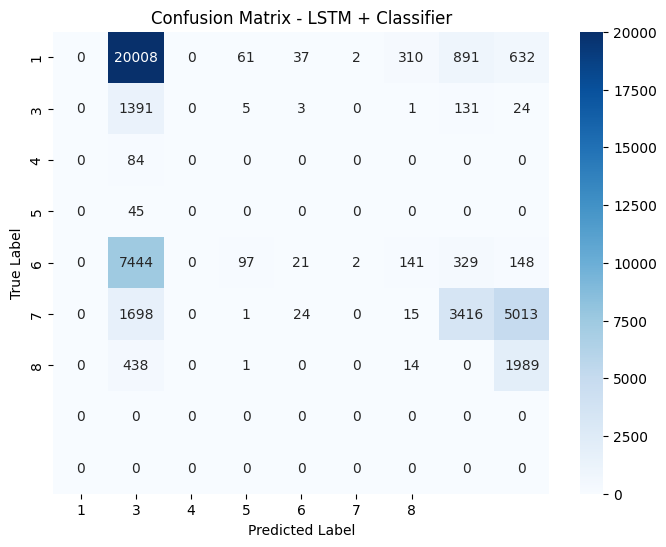

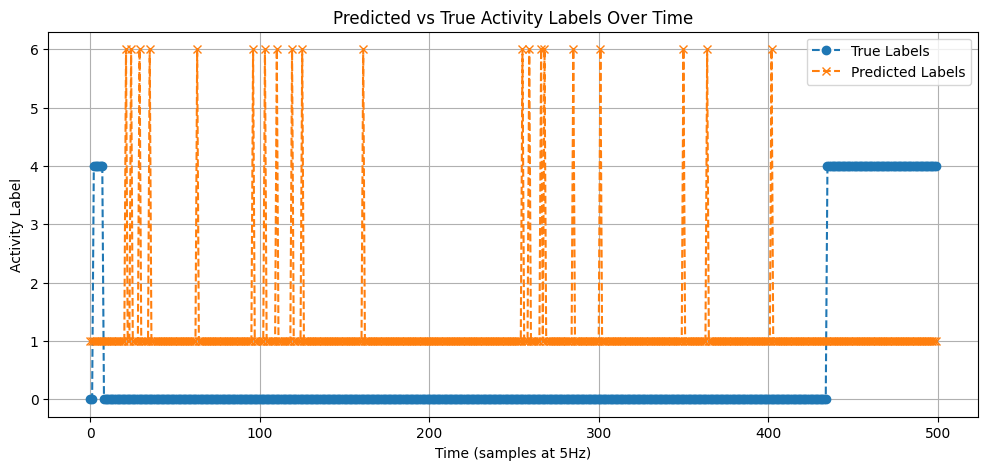

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM + Classifier")
plt.show()

# Plot predicted vs actual activity labels over time
time_range = 500  # Number of samples to visualize
y_pred_sample = predicted_labels[:time_range]
y_true_sample = true_labels[:time_range]

plt.figure(figsize=(12, 5))
plt.plot(y_true_sample, label="True Labels", linestyle='dashed', marker='o')
plt.plot(y_pred_sample, label="Predicted Labels", linestyle='dashed', marker='x')
plt.title("Predicted vs True Activity Labels Over Time")
plt.xlabel("Time (samples at 5Hz)")
plt.ylabel("Activity Label")
plt.legend()
plt.grid()
plt.show()


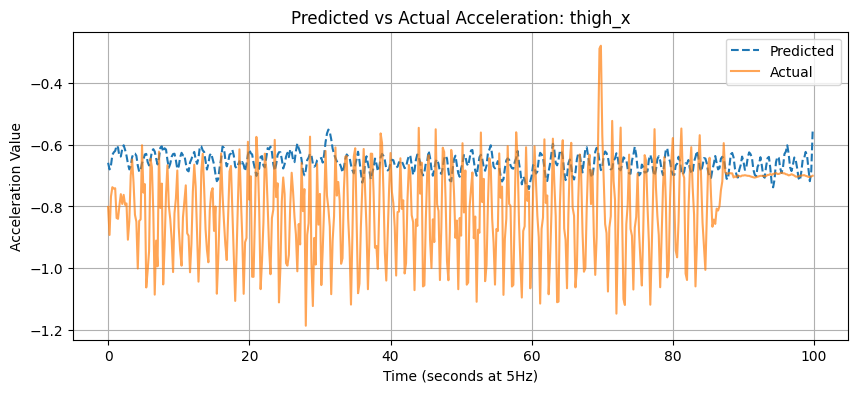

In [31]:
# Collect enough actual acceleration samples (500 needed)
actual_accel_values = []

for X_batch, y_batch in val_gen_accel:
    actual_accel_values.extend(y_batch[:, 0])  # Extract first feature column
    if len(actual_accel_values) >= time_range:  # Stop when we reach 500 samples
        break

# Convert to NumPy array and match shape
actual_accel_values = np.array(actual_accel_values[:time_range])  # Trim to exactly 500

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(time_range) / 5, predicted_accelerations[:time_range, 0], label="Predicted", linestyle="dashed")
plt.plot(np.arange(time_range) / 5, actual_accel_values, label="Actual", alpha=0.7)
plt.title(f"Predicted vs Actual Acceleration: {selected_features[0]}")
plt.xlabel("Time (seconds at 5Hz)")
plt.ylabel("Acceleration Value")
plt.legend()
plt.grid()
plt.show()


In [32]:
# Compute mean & std from original training data
accel_means = df_downsampled[selected_features].mean()
accel_stds = df_downsampled[selected_features].std()

# Inverse transform predictions
predicted_accelerations = (predicted_accelerations * accel_stds.values) + accel_means.values

# Also inverse transform actual values (if they were also normalized)
actual_accel_values = (actual_accel_values * accel_stds.values[0]) + accel_means.values[0]


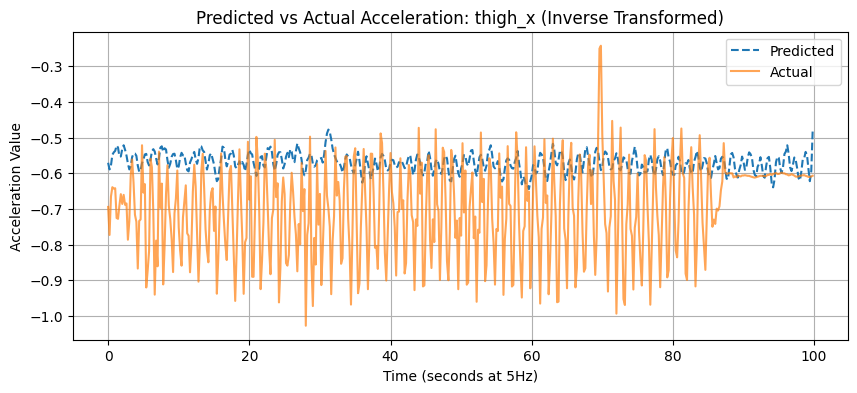

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(time_range) / 5, predicted_accelerations[:time_range, 0], label="Predicted", linestyle="dashed")
plt.plot(np.arange(time_range) / 5, actual_accel_values, label="Actual", alpha=0.7)
plt.title(f"Predicted vs Actual Acceleration: {selected_features[0]} (Inverse Transformed)")
plt.xlabel("Time (seconds at 5Hz)")
plt.ylabel("Acceleration Value")
plt.legend()
plt.grid()
plt.show()


In [34]:
print(df_downsampled.columns)  # Check column names
print(df_downsampled['subject_id'].unique())  # List unique individuals


Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label', 'subject_id', 'label_encoded'],
      dtype='object')
['501' '502' '503' '504' '505' '506' '507' '508' '509' '510' '511' '512'
 '513' '514' '515' '516' '517' '518']


In [35]:
# Create dictionary to store individual datasets
individual_datasets = {subject: df_downsampled[df_downsampled['subject_id'] == subject] for subject in df_downsampled['subject_id'].unique()}

# Print dataset sizes
for subject, df in individual_datasets.items():
    print(f"Subject {subject}: {len(df)} samples")


Subject 501: 10386 samples
Subject 502: 13137 samples
Subject 503: 11641 samples
Subject 504: 15076 samples
Subject 505: 8701 samples
Subject 506: 12271 samples
Subject 507: 12013 samples
Subject 508: 13049 samples
Subject 509: 12176 samples
Subject 510: 12207 samples
Subject 511: 12806 samples
Subject 512: 11931 samples
Subject 513: 12360 samples
Subject 514: 10151 samples
Subject 515: 15351 samples
Subject 516: 13828 samples
Subject 517: 14705 samples
Subject 518: 14171 samples


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Store models per subject
individual_models = {}

# Training parameters
look_back = 600  # 2 minutes at 5Hz
forecast_horizon = 150  # 30 seconds at 5Hz
batch_size = 128
epochs = 10

# Train one LSTM per individual
for subject, df_subject in individual_datasets.items():
    print(f"\n🚀 Training LSTM for Subject {subject}")

    # Create data generator for this subject
    train_gen_subject = HARAccelerationGenerator(df_subject, selected_features, look_back, forecast_horizon, batch_size=batch_size)
    
    # Define LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(look_back, len(selected_features))),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(len(selected_features), activation='linear')  # Predict accelerations
    ])
    
    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train model
    model.fit(train_gen_subject, epochs=epochs)
    
    # Store model
    individual_models[subject] = model

print("\n✅ Finished training all individual models!")



🚀 Training LSTM for Subject 501
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 792ms/step - loss: 0.6202 - mae: 0.5342
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 797ms/step - loss: 0.2540 - mae: 0.3231
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 790ms/step - loss: 0.2602 - mae: 0.3309
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 789ms/step - loss: 0.3327 - mae: 0.3621
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 785ms/step - loss: 0.3138 - mae: 0.3613
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 784ms/step - loss: 0.2237 - mae: 0.2811
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 790ms/step - loss: 0.2394 - mae: 0.3018
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 790ms/step - loss: 0.4312 - mae: 0.4073
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 790ms/step - loss: 0.1921 - mae: 0.2771
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 788ms/step - loss: 0.3645 - mae: 0.3831

🚀 Training LSTM for Subject 502


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 769ms/step - loss: 0.5195 - mae: 0.4487
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 753ms/step - loss: 0.2627 - mae: 0.3091
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 754ms/step - loss: 0.2181 - mae: 0.2834
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 754ms/step - loss: 0.3080 - mae: 0.3098
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 754ms/step - loss: 0.1748 - mae: 0.2408
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 751ms/step - loss: 0.1613 - mae: 0.2394
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 756ms/step - loss: 0.2318 - mae: 0.2694
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 756ms/step - loss: 0.2768 - mae: 0.2879
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 756ms/step - loss: 0.2501 - mae: 0.2950
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 753ms/step - loss: 0.2744 - mae: 0.3026

🚀 Training LSTM for Subject 503
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 731ms/step - loss: 0.5987 - mae: 0.5634
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 735ms/step - loss: 0.2413 - mae: 0.3213
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 739ms/step - loss: 0.3697 - mae: 0.4129
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.3075 - mae: 0.3708
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 732ms/step - loss: 0.3356 - mae: 0.3917
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.3016 - mae: 0.3466
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 727ms/step - loss: 0.4222 - mae: 0.4294
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 732ms/step - loss: 0.2574 - mae: 0.3206
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 737ms/step - loss: 0.2776 - mae: 0.3486
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 728ms/step - loss: 0.4278 - mae: 0.4150

🚀 Training LSTM for Subject 504
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 81s 716ms/step - loss: 0.4131 - mae: 0.3869
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 79s 710ms/step - loss: 0.6545 - mae: 0.4988
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 79s 712ms/step - loss: 0.3464 - mae: 0.3445
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 718ms/step - loss: 0.2939 - mae: 0.3154
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 718ms/step - loss: 0.2916 - mae: 0.3028
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 79s 714ms/step - loss: 0.2357 - mae: 0.2809
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 79s 714ms/step - loss: 0.4120 - mae: 0.3534
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 720ms/step - loss: 0.3116 - mae: 0.3114
Epoch 9/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 719ms/step - loss: 0.2539 - mae: 0.2902
Epoch 10/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 717ms/step - loss: 0.3922 - mae: 0.3508

🚀 Training LSTM for Subject 505
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 710ms/step - loss: 0.7598 - mae: 0.6791
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 716ms/step - loss: 0.3867 - mae: 0.4376
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 715ms/step - loss: 0.5061 - mae: 0.4800
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 719ms/step - loss: 0.4292 - mae: 0.4120
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 716ms/step - loss: 0.3447 - mae: 0.4376
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 713ms/step - loss: 0.3760 - mae: 0.4155
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 717ms/step - loss: 0.3821 - mae: 0.4131
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 716ms/step - loss: 0.4090 - mae: 0.4284
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 712ms/step - loss: 0.4989 - mae: 0.4932
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 714ms/step - loss: 0.4688 - mae: 0.4859

🚀 Training LSTM for Subject 506
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 695ms/step - loss: 0.4363 - mae: 0.4606
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 701ms/step - loss: 0.2216 - mae: 0.2797
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 703ms/step - loss: 0.2174 - mae: 0.2673
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 698ms/step - loss: 0.1980 - mae: 0.2684
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 697ms/step - loss: 0.2468 - mae: 0.2747
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 697ms/step - loss: 0.3468 - mae: 0.3389
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 704ms/step - loss: 0.1513 - mae: 0.2221
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 703ms/step - loss: 0.1698 - mae: 0.2442
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 701ms/step - loss: 0.1493 - mae: 0.2358
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 702ms/step - loss: 0.2088 - mae: 0.2606

🚀 Training LSTM for Subject 507
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 62s 694ms/step - loss: 0.3405 - mae: 0.3633
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 694ms/step - loss: 0.3461 - mae: 0.3470
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 700ms/step - loss: 0.4014 - mae: 0.3747
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 694ms/step - loss: 0.3718 - mae: 0.3354
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 694ms/step - loss: 0.4633 - mae: 0.3736
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 693ms/step - loss: 0.5291 - mae: 0.4328
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 690ms/step - loss: 0.3192 - mae: 0.3255
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 692ms/step - loss: 0.3103 - mae: 0.3231
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 695ms/step - loss: 0.3543 - mae: 0.3396
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 695ms/step - loss: 0.3200 - mae: 0.3210

🚀 Training LSTM for Subject 508
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 685ms/step - loss: 0.4427 - mae: 0.4687
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 686ms/step - loss: 0.2753 - mae: 0.3452
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 682ms/step - loss: 0.2525 - mae: 0.2981
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 688ms/step - loss: 0.3441 - mae: 0.3572
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 691ms/step - loss: 0.1702 - mae: 0.2568
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 688ms/step - loss: 0.2642 - mae: 0.3164
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 687ms/step - loss: 0.1832 - mae: 0.2636
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 686ms/step - loss: 0.1619 - mae: 0.2522
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 685ms/step - loss: 0.1995 - mae: 0.2708
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 686ms/step - loss: 0.2400 - mae: 0.2927

🚀 Training LSTM for Subject 509
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 689ms/step - loss: 0.4149 - mae: 0.4468
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 686ms/step - loss: 0.2024 - mae: 0.2943
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 688ms/step - loss: 0.2952 - mae: 0.3439
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 683ms/step - loss: 0.1870 - mae: 0.2745
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 685ms/step - loss: 0.2186 - mae: 0.2866
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 692ms/step - loss: 0.2023 - mae: 0.2717
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 690ms/step - loss: 0.1396 - mae: 0.2366
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 688ms/step - loss: 0.1627 - mae: 0.2552
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 690ms/step - loss: 0.1517 - mae: 0.2415
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 686ms/step - loss: 0.1836 - mae: 0.2747

🚀 Training LSTM for Subject 510
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 684ms/step - loss: 0.6266 - mae: 0.5620
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 691ms/step - loss: 0.4037 - mae: 0.3922
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 687ms/step - loss: 0.4053 - mae: 0.3859
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 688ms/step - loss: 0.2715 - mae: 0.3201
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 685ms/step - loss: 0.3801 - mae: 0.3718
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 685ms/step - loss: 0.2579 - mae: 0.3226
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 689ms/step - loss: 0.3130 - mae: 0.3411
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 690ms/step - loss: 0.2597 - mae: 0.3291
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 688ms/step - loss: 0.2971 - mae: 0.3362
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 686ms/step - loss: 0.3910 - mae: 0.3694

🚀 Training LSTM for Subject 511
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 680ms/step - loss: 0.4646 - mae: 0.4996
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 681ms/step - loss: 0.3179 - mae: 0.3785
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 687ms/step - loss: 0.2744 - mae: 0.3217
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 687ms/step - loss: 0.3378 - mae: 0.3641
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 684ms/step - loss: 0.2376 - mae: 0.3192
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 681ms/step - loss: 0.2892 - mae: 0.3437
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 682ms/step - loss: 0.2635 - mae: 0.3022
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 683ms/step - loss: 0.2727 - mae: 0.3399
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 688ms/step - loss: 0.1520 - mae: 0.2534
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 685ms/step - loss: 0.2156 - mae: 0.3063

🚀 Training LSTM for Subject 512
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 678ms/step - loss: 0.7791 - mae: 0.5161
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 680ms/step - loss: 0.3915 - mae: 0.3811
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 677ms/step - loss: 0.4233 - mae: 0.4078
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 682ms/step - loss: 0.5066 - mae: 0.4306
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 686ms/step - loss: 0.3571 - mae: 0.3659
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 685ms/step - loss: 0.5274 - mae: 0.4476
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 683ms/step - loss: 0.5240 - mae: 0.3811
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 682ms/step - loss: 0.5627 - mae: 0.4178
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 680ms/step - loss: 0.4468 - mae: 0.3851
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 683ms/step - loss: 0.4483 - mae: 0.3755

🚀 Training LSTM for Subject 513
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 689ms/step - loss: 0.7754 - mae: 0.6117
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 687ms/step - loss: 0.4470 - mae: 0.4480
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 685ms/step - loss: 0.4364 - mae: 0.4369
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 685ms/step - loss: 0.4737 - mae: 0.4640
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 684ms/step - loss: 0.5308 - mae: 0.4603
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 688ms/step - loss: 0.4260 - mae: 0.4366
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 689ms/step - loss: 0.3163 - mae: 0.3626
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 686ms/step - loss: 0.4469 - mae: 0.4744
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 688ms/step - loss: 0.4392 - mae: 0.4111
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 687ms/step - loss: 0.4079 - mae: 0.4367

🚀 Training LSTM for Subject 514
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 683ms/step - loss: 0.8176 - mae: 0.6223
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 683ms/step - loss: 0.6573 - mae: 0.5219
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 692ms/step - loss: 0.7399 - mae: 0.5909
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 692ms/step - loss: 0.6910 - mae: 0.6079
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 691ms/step - loss: 0.6468 - mae: 0.5462
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 691ms/step - loss: 0.4699 - mae: 0.4513
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 690ms/step - loss: 0.5841 - mae: 0.5506
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 687ms/step - loss: 0.5652 - mae: 0.4785
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 690ms/step - loss: 0.5863 - mae: 0.5485
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 697ms/step - loss: 0.4111 - mae: 0.3918

🚀 Training LSTM for Subject 515
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 700ms/step - loss: 0.5061 - mae: 0.5133
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 699ms/step - loss: 0.4250 - mae: 0.4327
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 695ms/step - loss: 0.2837 - mae: 0.3332
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 697ms/step - loss: 0.2463 - mae: 0.3201
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 704ms/step - loss: 0.3098 - mae: 0.3677
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 699ms/step - loss: 0.2811 - mae: 0.3353
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 697ms/step - loss: 0.2286 - mae: 0.2953
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 700ms/step - loss: 0.2968 - mae: 0.3418
Epoch 9/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 700ms/step - loss: 0.2742 - mae: 0.3625
Epoch 10/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 701ms/step - loss: 0.2570 - mae: 0.3295

🚀 Training LSTM for Subject 516
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 73s 694ms/step - loss: 0.4995 - mae: 0.4066
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 70s 689ms/step - loss: 0.5330 - mae: 0.4377
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 692ms/step - loss: 0.3028 - mae: 0.3071
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 697ms/step - loss: 0.3311 - mae: 0.3146
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 696ms/step - loss: 0.6611 - mae: 0.5085
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 697ms/step - loss: 0.3522 - mae: 0.3181
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 693ms/step - loss: 0.3849 - mae: 0.3841
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 694ms/step - loss: 0.4174 - mae: 0.3605
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 694ms/step - loss: 0.4313 - mae: 0.3586
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 693ms/step - loss: 0.3892 - mae: 0.3589

🚀 Training LSTM for Subject 517
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 697ms/step - loss: 0.5573 - mae: 0.5465
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 695ms/step - loss: 0.3565 - mae: 0.4058
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 694ms/step - loss: 0.4370 - mae: 0.4371
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 702ms/step - loss: 0.3477 - mae: 0.3835
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 698ms/step - loss: 0.4704 - mae: 0.4579
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 698ms/step - loss: 0.4399 - mae: 0.4359
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 694ms/step - loss: 0.3413 - mae: 0.3789
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 695ms/step - loss: 0.4280 - mae: 0.4409
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 700ms/step - loss: 0.3389 - mae: 0.3890
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 700ms/step - loss: 0.4241 - mae: 0.4344

🚀 Training LSTM for Subject 518
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 702ms/step - loss: 0.4514 - mae: 0.5116
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 701ms/step - loss: 0.2759 - mae: 0.3396
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 702ms/step - loss: 0.3396 - mae: 0.3711
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 707ms/step - loss: 0.3307 - mae: 0.3473
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 706ms/step - loss: 0.2486 - mae: 0.3082
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 702ms/step - loss: 0.3548 - mae: 0.3727
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 700ms/step - loss: 0.2334 - mae: 0.2915
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 703ms/step - loss: 0.1474 - mae: 0.2212
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 706ms/step - loss: 0.1935 - mae: 0.2807
Epoch 10/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 703ms/step - loss: 0.2493 - mae: 0.2967

✅ Finished training all individual models!


In [41]:
from sklearn.ensemble import RandomForestClassifier

# Store classifiers per subject
individual_classifiers = {}

for subject, df_subject in individual_datasets.items():
    print(f"\n🚀 Training Classifier for Subject {subject}")

    # Extract training data
    X = df_subject[selected_features]
    y = df_subject["label"]

    # Train a classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)

    # Store model
    individual_classifiers[subject] = clf

print("\n✅ Finished training all individual classifiers!")



🚀 Training Classifier for Subject 501

🚀 Training Classifier for Subject 502

🚀 Training Classifier for Subject 503

🚀 Training Classifier for Subject 504

🚀 Training Classifier for Subject 505

🚀 Training Classifier for Subject 506

🚀 Training Classifier for Subject 507

🚀 Training Classifier for Subject 508

🚀 Training Classifier for Subject 509

🚀 Training Classifier for Subject 510

🚀 Training Classifier for Subject 511

🚀 Training Classifier for Subject 512

🚀 Training Classifier for Subject 513

🚀 Training Classifier for Subject 514

🚀 Training Classifier for Subject 515

🚀 Training Classifier for Subject 516

🚀 Training Classifier for Subject 517

🚀 Training Classifier for Subject 518

✅ Finished training all individual classifiers!


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


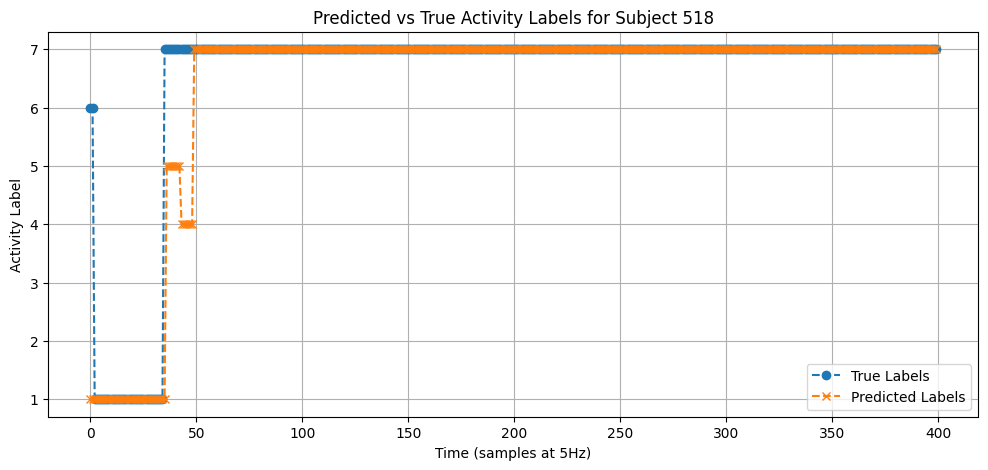

In [44]:
# Select a test subject (e.g., subject 1)
test_subject = '518'

# Load LSTM model and classifier for this individual
lstm_model = individual_models[test_subject]
classifier = individual_classifiers[test_subject]

# Get test data
df_test = individual_datasets[test_subject].iloc[:1000]  # Take a subset for testing

# Predict future accelerations using LSTM
X_test_lstm = np.array([df_test[selected_features].values[i : i + look_back] for i in range(len(df_test) - look_back)])
predicted_accelerations = lstm_model.predict(X_test_lstm)

# Predict activity labels using classifier
predicted_labels = classifier.predict(predicted_accelerations)

# Compare to true labels
true_labels = df_test["label"].iloc[look_back:].values

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(true_labels, label="True Labels", linestyle='dashed', marker='o')
plt.plot(predicted_labels, label="Predicted Labels", linestyle='dashed', marker='x')
plt.title(f"Predicted vs True Activity Labels for Subject {test_subject}")
plt.xlabel("Time (samples at 5Hz)")
plt.ylabel("Activity Label")
plt.legend()
plt.grid()
plt.show()


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Directory to save confusion matrix plots
conf_matrix_dir = "individual_confusion_matrices/"
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

# Generate confusion matrix for each individual
for subject, df_subject in individual_datasets.items():
    print(f"\n🚀 Generating Confusion Matrix for Subject {subject}")

    # Load classifier for this subject
    classifier = individual_classifiers[subject]

    # Prepare LSTM test input
    X_full_lstm = np.array([df_subject[selected_features].values[i : i + look_back] 
                             for i in range(len(df_subject) - look_back)])

    # Predict future accelerations using LSTM
    predicted_accelerations = individual_models[subject].predict(X_full_lstm)

    # Convert predictions to DataFrame with correct feature names
    predicted_accelerations_df = pd.DataFrame(predicted_accelerations, columns=selected_features)

    # Predict activity labels using classifier
    predicted_labels = classifier.predict(predicted_accelerations_df)

    # Get true labels
    true_labels = df_subject["label"].iloc[look_back:].values

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Subject {subject}")

    # Save confusion matrix as an image
    conf_matrix_filename = f"{conf_matrix_dir}subject_{subject}_confusion_matrix.png"
    plt.savefig(conf_matrix_filename)
    plt.close()

    print(f"✅ Saved Confusion Matrix for Subject {subject} at {conf_matrix_filename}")



🚀 Generating Confusion Matrix for Subject 501
306/306 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step
✅ Saved Confusion Matrix for Subject 501 at individual_confusion_matrices/subject_501_confusion_matrix.png

🚀 Generating Confusion Matrix for Subject 502
392/392 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step
✅ Saved Confusion Matrix for Subject 502 at individual_confusion_matrices/subject_502_confusion_matrix.png

🚀 Generating Confusion Matrix for Subject 503
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step
✅ Saved Confusion Matrix for Subject 503 at individual_confusion_matrices/subject_503_confusion_matrix.png

🚀 Generating Confusion Matrix for Subject 504
453/453 ━━━━━━━━━━━━━━━━━━━━ 62s 137ms/step
✅ Saved Confusion Matrix for Subject 504 at individual_confusion_matrices/subject_504_confusion_matrix.png

🚀 Generating Confusion Matrix for Subject 505
254/254 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step
✅ Saved Confusion Matrix for Subject 505 at individual_confusion_matrices/subject_505_confusion_matrix.png

🚀 Generat


📊 Showing: subject_501_confusion_matrix.png


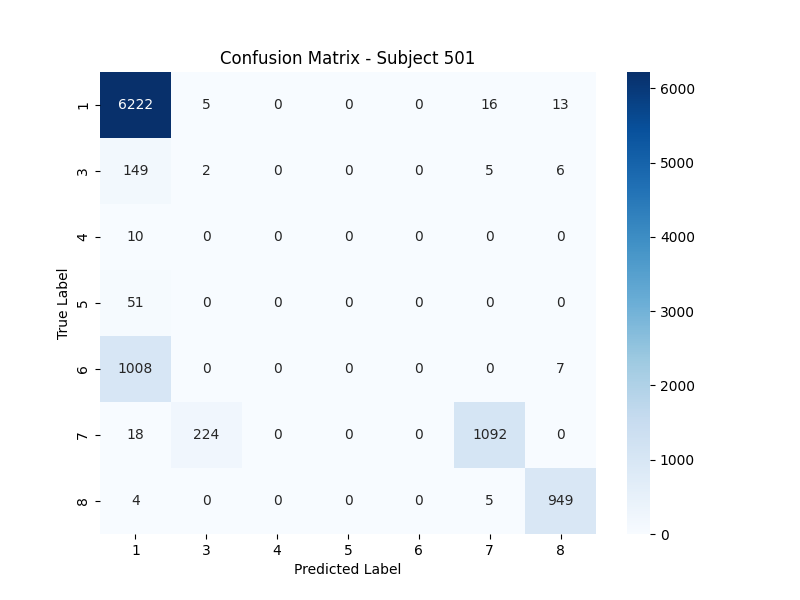


📊 Showing: subject_502_confusion_matrix.png


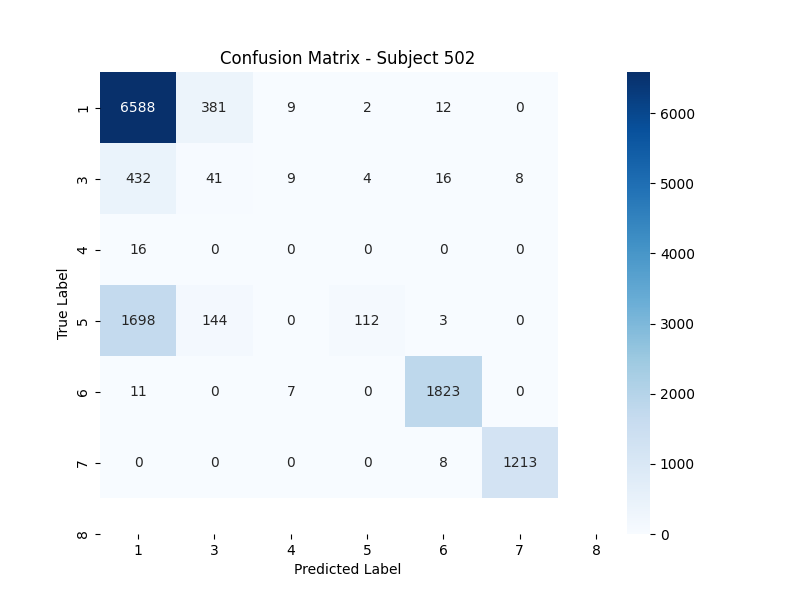


📊 Showing: subject_503_confusion_matrix.png


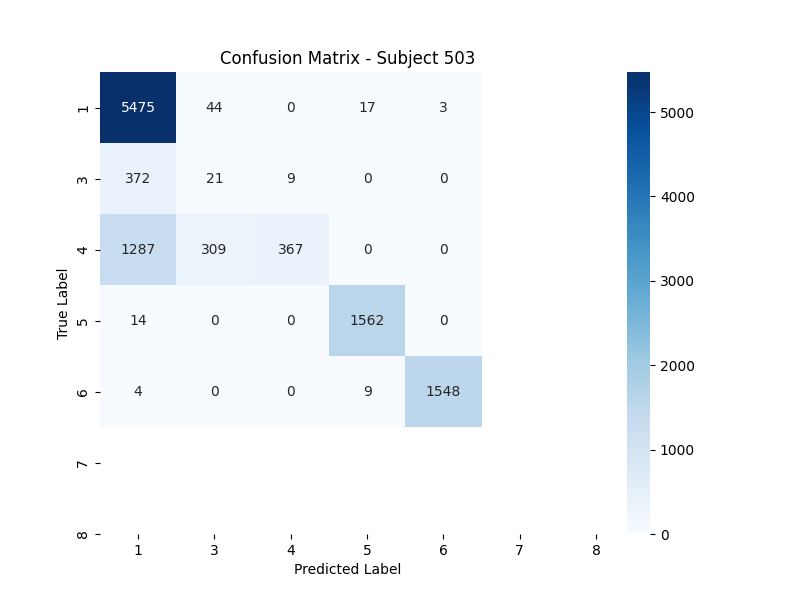


📊 Showing: subject_504_confusion_matrix.png


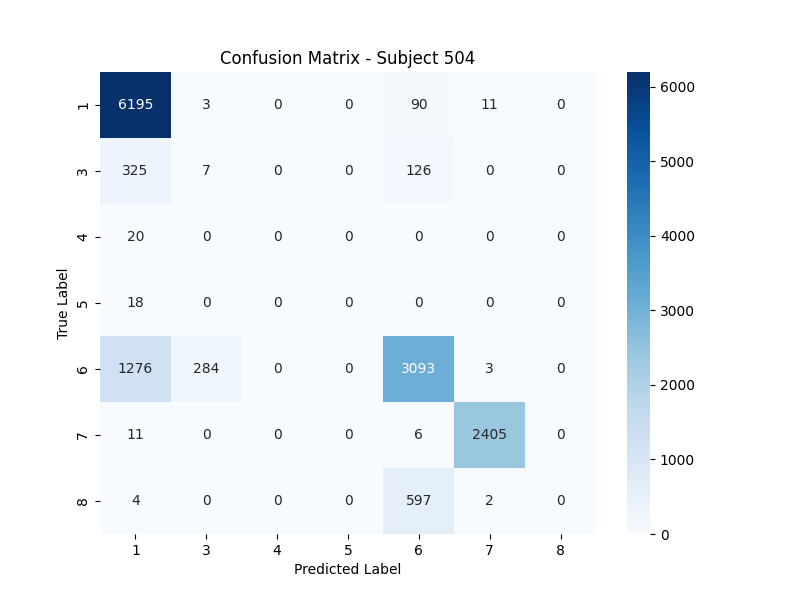


📊 Showing: subject_505_confusion_matrix.png


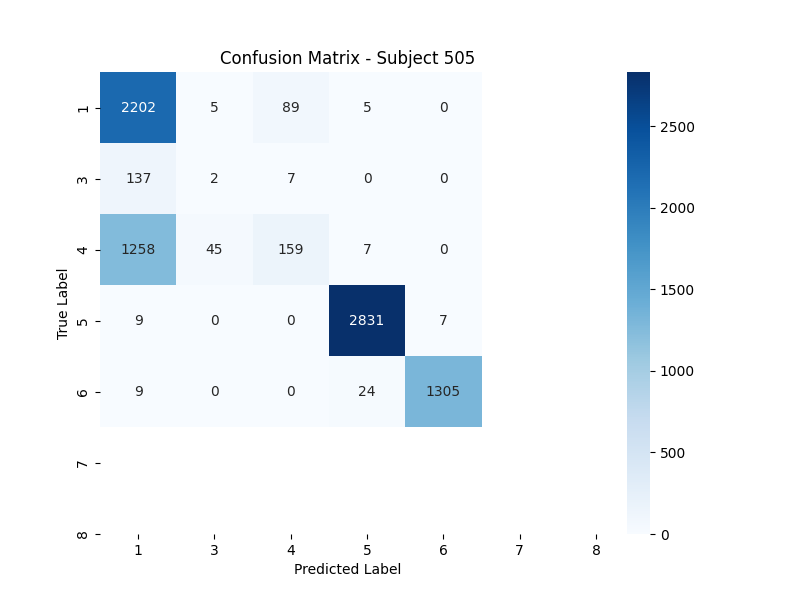


📊 Showing: subject_506_confusion_matrix.png


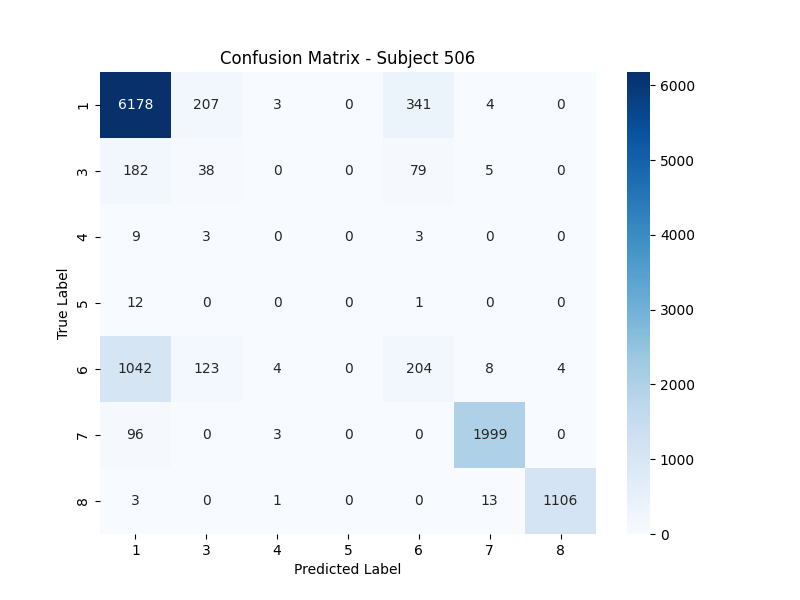


📊 Showing: subject_507_confusion_matrix.png


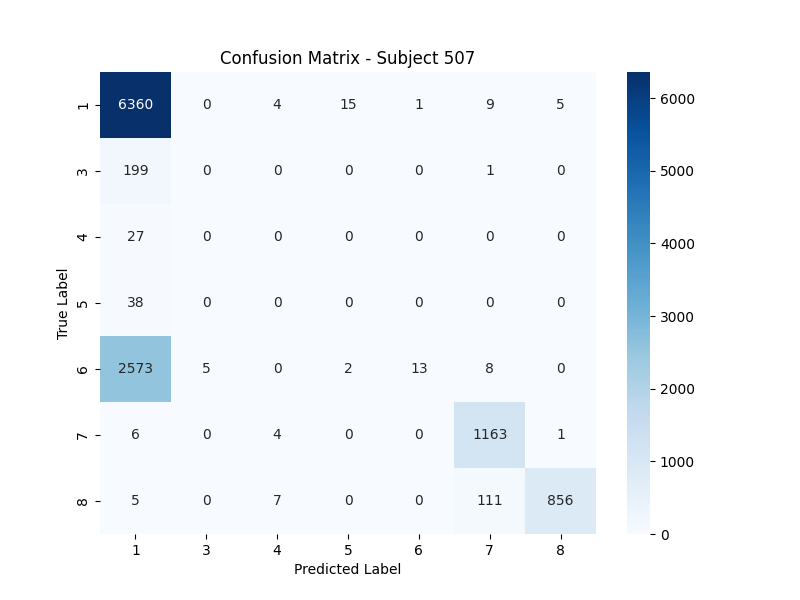


📊 Showing: subject_508_confusion_matrix.png


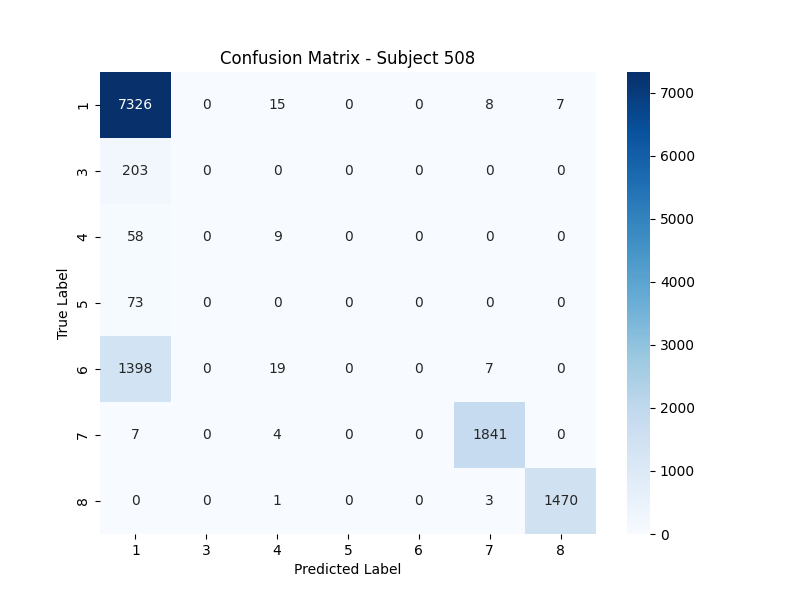


📊 Showing: subject_509_confusion_matrix.png


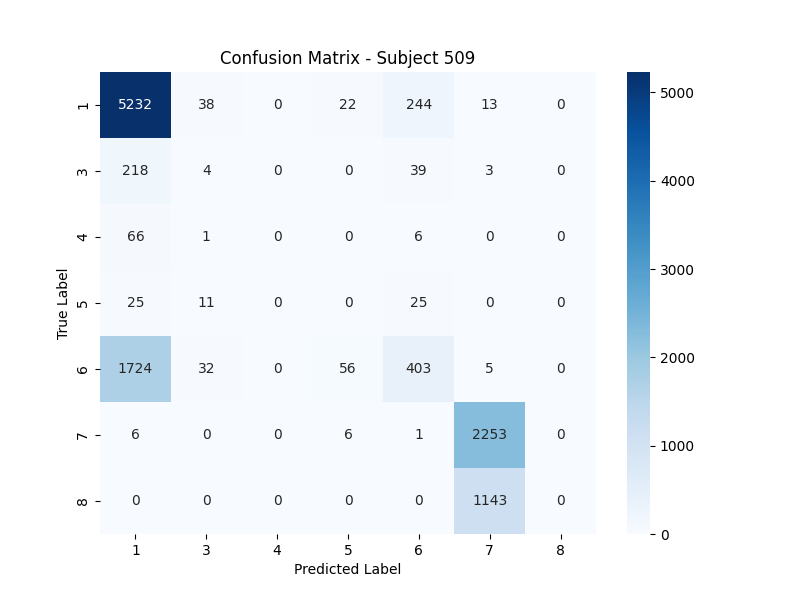


📊 Showing: subject_510_confusion_matrix.png


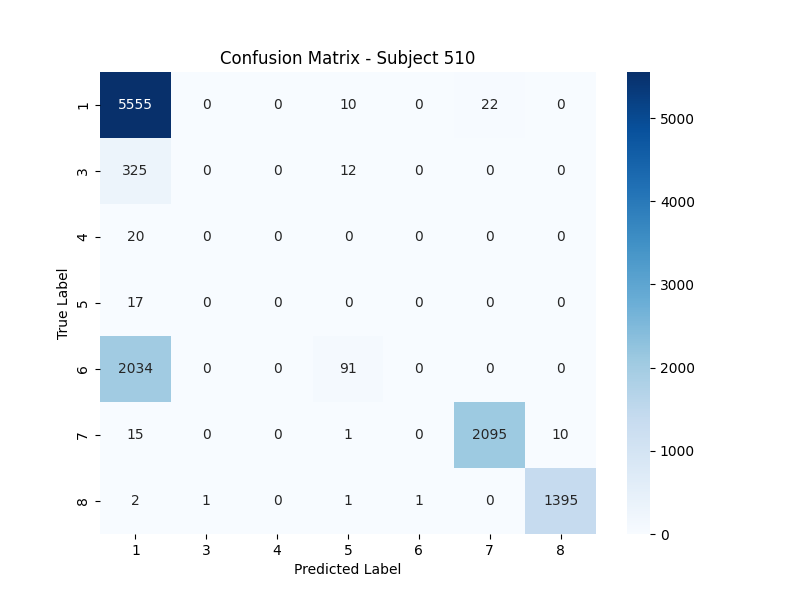


📊 Showing: subject_511_confusion_matrix.png


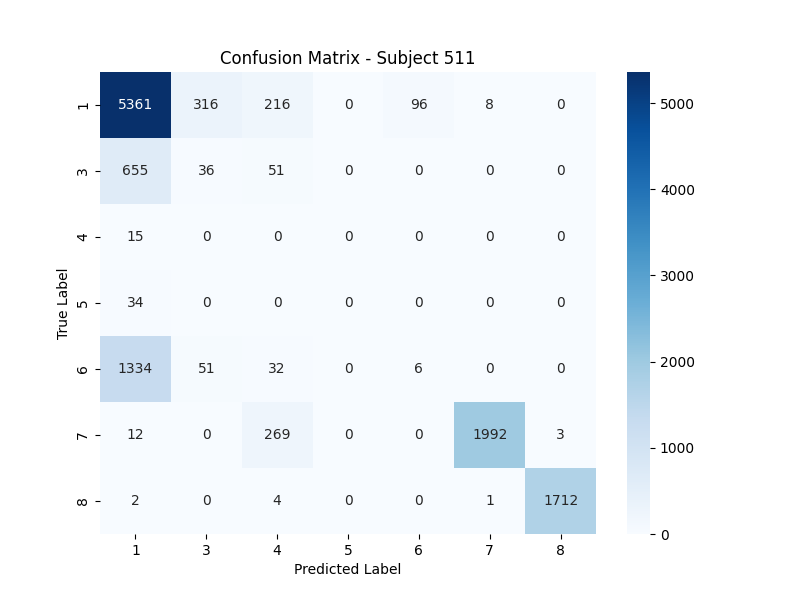


📊 Showing: subject_512_confusion_matrix.png


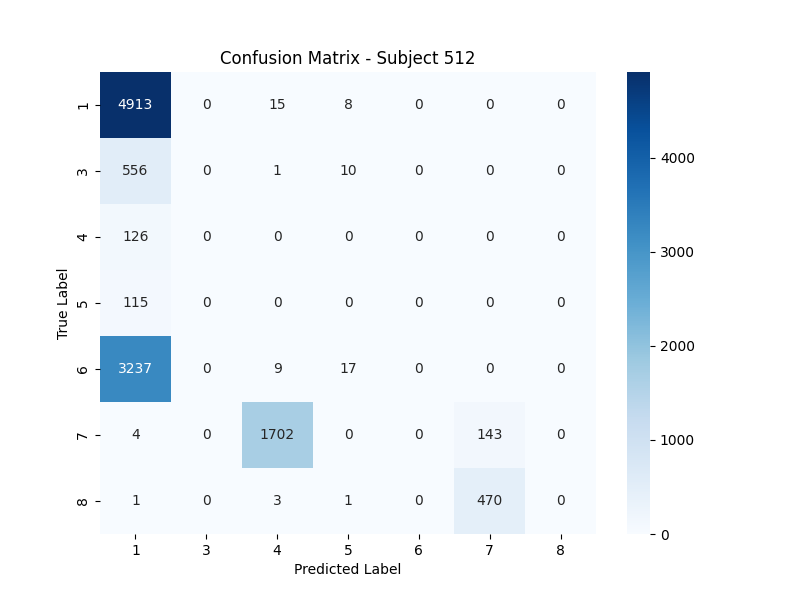


📊 Showing: subject_513_confusion_matrix.png


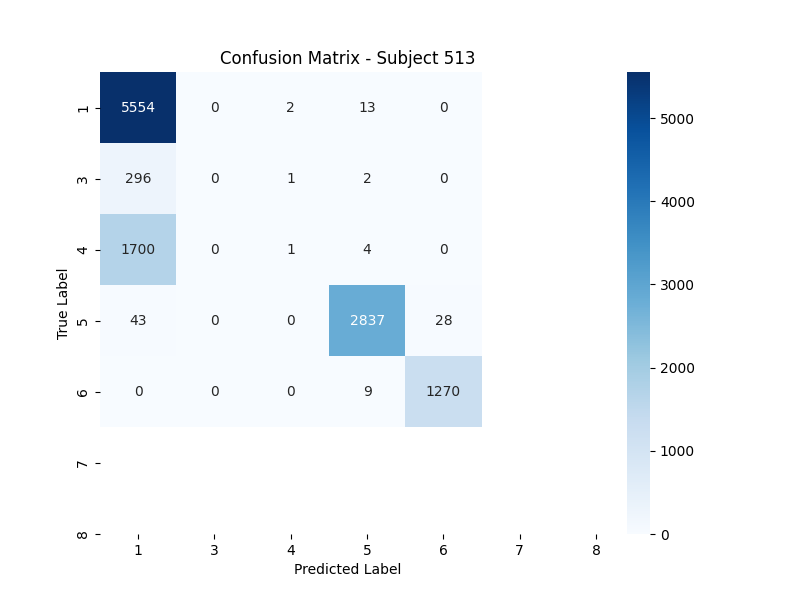


📊 Showing: subject_514_confusion_matrix.png


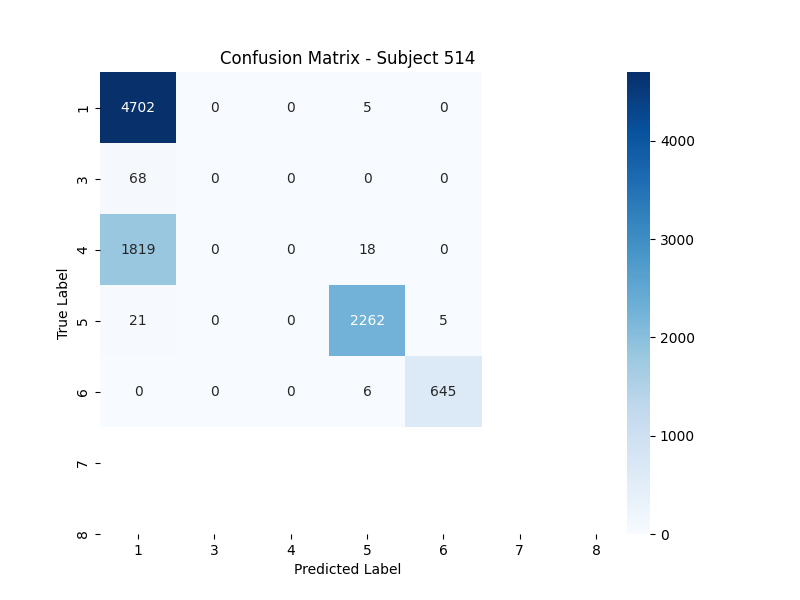


📊 Showing: subject_515_confusion_matrix.png


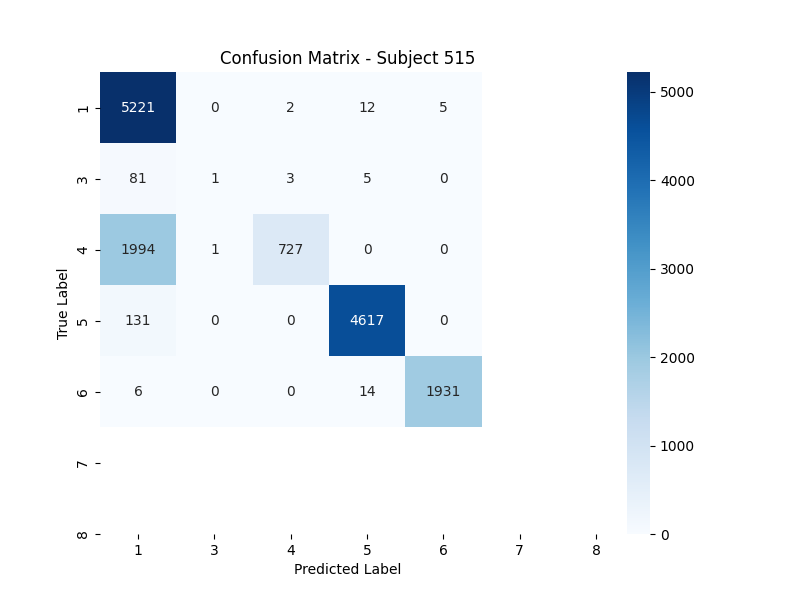


📊 Showing: subject_516_confusion_matrix.png


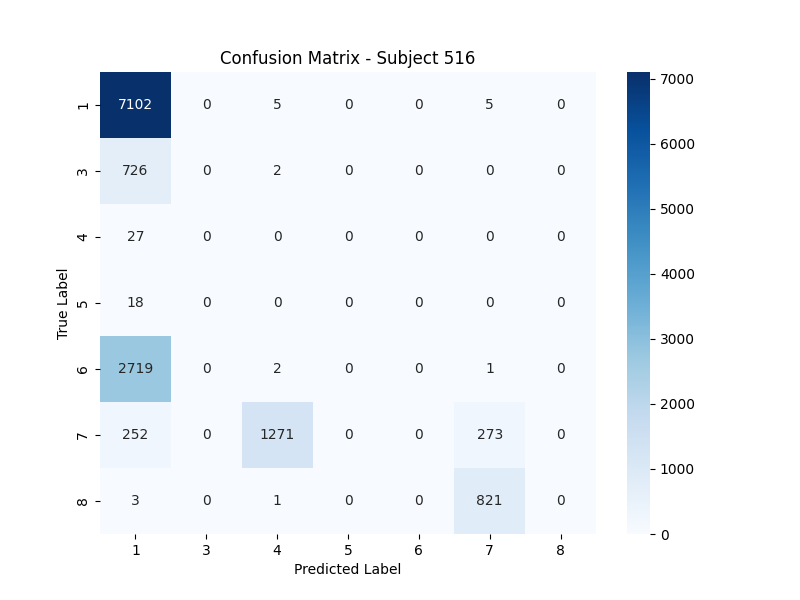


📊 Showing: subject_517_confusion_matrix.png


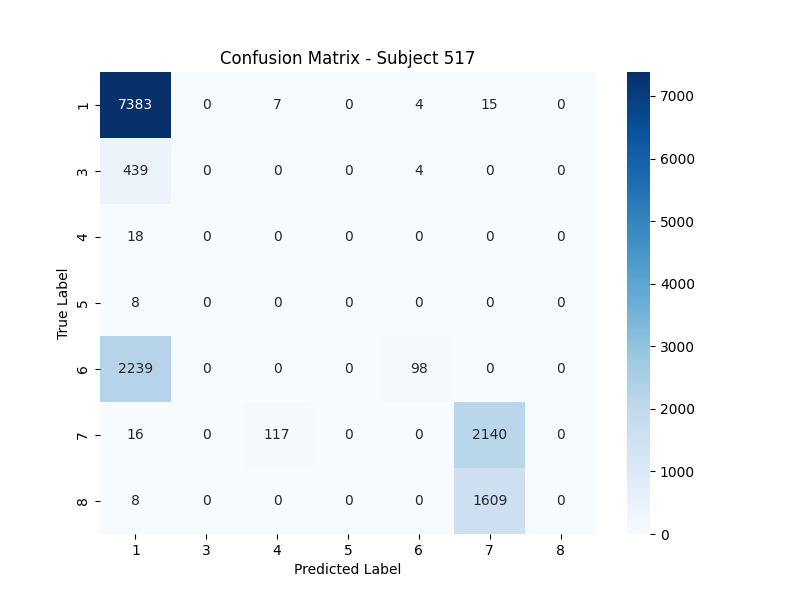


📊 Showing: subject_518_confusion_matrix.png


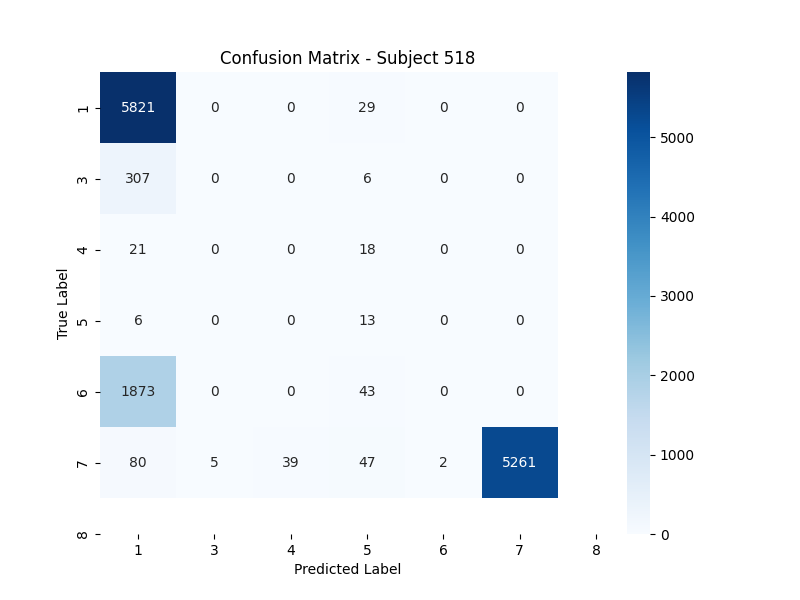

In [50]:
from IPython.display import display
from PIL import Image
import os

# Get all confusion matrix images
conf_matrix_images = sorted(os.listdir(conf_matrix_dir))

# Display all confusion matrices
for img_filename in conf_matrix_images:
    img_path = os.path.join(conf_matrix_dir, img_filename)
    print(f"\n📊 Showing: {img_filename}")
    display(Image.open(img_path))


In [47]:
import pandas as pd
import numpy as np
import os

# Directory to save files
output_dir = "individual_predictions/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save results for each individual
for subject, df_subject in individual_datasets.items():
    print(f"\n🚀 Processing Subject {subject}")

    # Load LSTM model and classifier
    lstm_model = individual_models[subject]
    classifier = individual_classifiers[subject]

    # Prepare input sequences for LSTM
    X_full_lstm = np.array([df_subject[selected_features].values[i : i + look_back] 
                             for i in range(len(df_subject) - look_back)])

    # Predict future accelerations using LSTM for the entire dataset
    
    predicted_accelerations = lstm_model.predict(X_full_lstm)
    # Convert LSTM-predicted accelerations back to a DataFrame with correct feature names
    predicted_accelerations_df = pd.DataFrame(predicted_accelerations, columns=selected_features)
    
    # Now, predict activity labels using the classifier
    predicted_labels = classifier.predict(predicted_accelerations_df)

    # Predict activity labels using classifier
    #predicted_labels = classifier.predict(predicted_accelerations)

    # Extract actual values
    actual_accelerations = df_subject[selected_features].iloc[look_back:].values
    actual_labels = df_subject["label"].iloc[look_back:].values

    # Create a time column (5Hz intervals)
    time_seconds = np.arange(len(actual_labels)) / 5  # Convert samples to seconds

    # Create DataFrame
    df_results = pd.DataFrame({
        "Time (s)": time_seconds,
        "Actual Label": actual_labels,
        "Predicted Label": predicted_labels
    })

    # Add actual and predicted acceleration values
    for i, feature in enumerate(selected_features):
        df_results[f"Actual {feature}"] = actual_accelerations[:, i]
        df_results[f"Predicted {feature}"] = predicted_accelerations[:, i]

    # Save to CSV
    csv_filename = f"{output_dir}subject_{subject}_full_predictions.csv"
    df_results.to_csv(csv_filename, index=False)
    print(f"✅ Saved FULL dataset predictions for Subject {subject} to {csv_filename}")



🚀 Processing Subject 501
306/306 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step
✅ Saved FULL dataset predictions for Subject 501 to individual_predictions/subject_501_full_predictions.csv

🚀 Processing Subject 502
392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step
✅ Saved FULL dataset predictions for Subject 502 to individual_predictions/subject_502_full_predictions.csv

🚀 Processing Subject 503
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step
✅ Saved FULL dataset predictions for Subject 503 to individual_predictions/subject_503_full_predictions.csv

🚀 Processing Subject 504
453/453 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step
✅ Saved FULL dataset predictions for Subject 504 to individual_predictions/subject_504_full_predictions.csv

🚀 Processing Subject 505
254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step
✅ Saved FULL dataset predictions for Subject 505 to individual_predictions/subject_505_full_predictions.csv

🚀 Processing Subject 506
365/365 ━━━━━━━━━━━━━━━━━━━━ 51s 140ms/step
✅ Saved FULL dataset predictions for Sub